# **Interview task**

Task: create a jupyter notebook to train a segmentation model for damage detection based on the given training data.

In [60]:
import os
import sys
import json
import datetime
import random
import numpy as np
import skimage.draw
import cv2
import re
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt

# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
from mrcnn.model import log

In [62]:
# Define paths of folders
dataset_path = os.path.join(".", "dataset")
test_images = os.path.join(".", "test")
logs = weights_path = os.path.join(".", "logs")
weights_path = os.path.join(".", "mask_rcnn_coco.h5")

## **1) Classes and function**
### a) Configurations

In [4]:
class CustomConfig(Config):
    """
    Configuration to train on the given dataset that overrides some of the values
    """
    NAME = "damage"
    IMAGES_PER_GPU = 2 # GPU with 12GB memory can fit two images.
    NUM_CLASSES = 1 + 1  # Background + damage
    STEPS_PER_EPOCH = 50
    DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
    BACKBONE = "resnet50"
    

class InferenceConfig(CustomConfig):
    """
    Configuration to evaluate the model on test images
    Set batch size to 1 (inference on one image at a time).
    """
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

### b) Dataset

In [5]:
class myDataset(utils.Dataset):

    def load_custom(self, dataset_dir, mode):
        
        # Add "damage" class
        self.add_class("damage", 1, "damage")

        # Train or validation dataset
        dataset_dir = os.path.join(dataset_dir, mode)

        # Load annotations (x and y coordinates of each region)
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())

        # Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinates of polygon vertexes for each object instance
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # retrieve the image size to convert polygons to masks.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "damage",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        
        # Convert polygons to a bitmap mask of shape [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        
        info = self.image_info[image_id]
        if info["source"] == "damage":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

### c) Training function

In [8]:
def train(model):

    # Training dataset.
    dataset_train = myDataset()
    dataset_train.load_custom(dataset_path, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = myDataset()
    dataset_val.load_custom(dataset_path, "val")
    dataset_val.prepare()

    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=5,
                layers='heads')

### d) Color masks functions

In [9]:
def color_splash(image, mask):
    """
    Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash


def detect_and_color_splash(model, image_path=None):
    """
    Run model detection and generate the color splash effect
    """
    print("Running on {}".format(image_path))
    # Read image
    image = skimage.io.imread(image_path)
    # Detect objects
    r = model.detect([image], verbose=1)[0]
    # Color splash
    splash = color_splash(image, r['masks'])
    # Save output
    file_name = "image/detected_damage_{}.png".format(image_path.split("/")[-1].split(".")[0])
    skimage.io.imsave(file_name, splash)

    print("Saved", file_name)

### e) Visualization function

In [63]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## **2) Dataset exploration**

Images count and number of classes

In [64]:
dataset = myDataset()
dataset.load_custom(dataset_path, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 49
Class Count: 2
  0. BG                                                
  1. damage                                            


Display some random samples

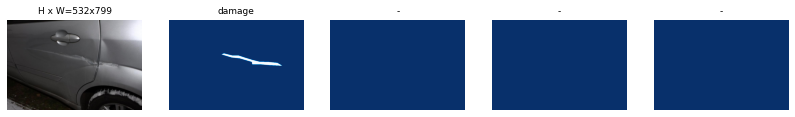

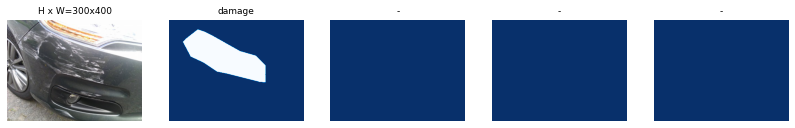

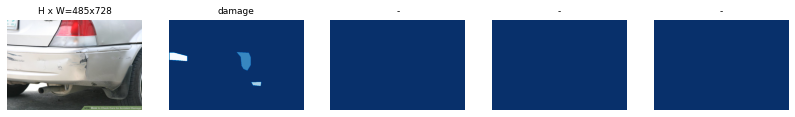

In [66]:
image_ids = np.random.choice(dataset.image_ids, 3)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

Show bounding boxes (computed from the updated mask)

image_id  16 ./dataset/train/image51.png
image                    shape: (528, 705, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (528, 705, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  182.00000  max:  443.00000  int32


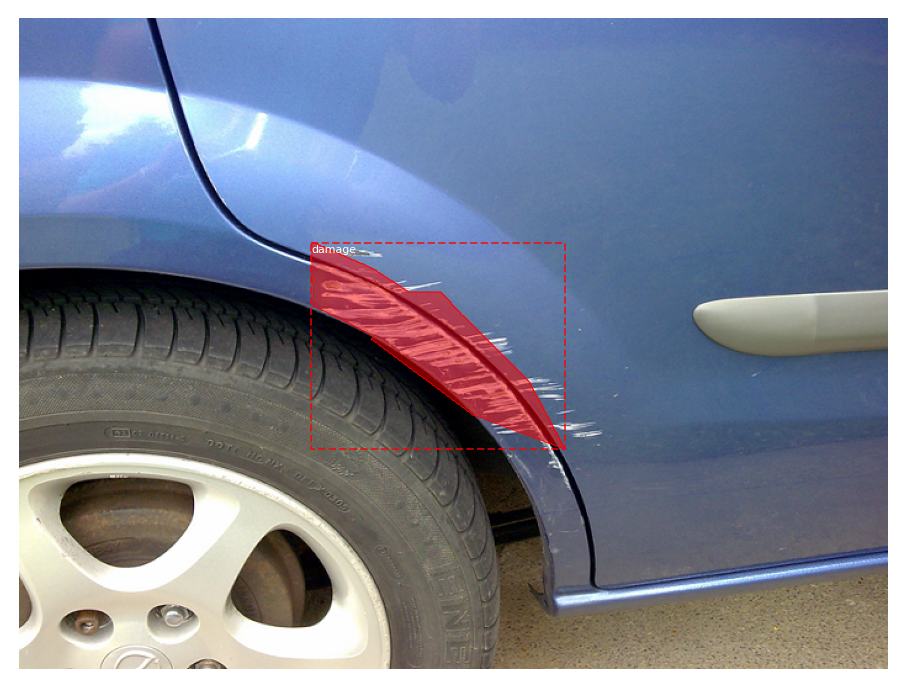

In [67]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## **3) Training step**

In [10]:
# Training configuration
config = CustomConfig()
# config.display()

# Define model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=logs)

# Loading pre-trained weights excluding the last layers because they require a matching number of classes
print("Loading weights from", weights_path)
model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])

# Train model
train(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loading weights from ./mask_rcnn_coco.h5

Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs/damage20220314T1029/mask_rcnn_damage_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1  

/home/luca/interview/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/luca/interview/lib/python3.6/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
49/50 [============================>.] - ETA: 46s - loss: 2.2485 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 0.7155 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.7085 - mrcnn_mask_loss: 0.5326

/home/luca/interview/lib/python3.6/site-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


50/50 [==============================] - 3065s - loss: 2.2404 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.7115 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.7053 - mrcnn_mask_loss: 0.5343 - val_loss: 2.0254 - val_rpn_class_loss: 0.0394 - val_rpn_bbox_loss: 0.7926 - val_mrcnn_class_loss: 0.0472 - val_mrcnn_bbox_loss: 0.6482 - val_mrcnn_mask_loss: 0.4979
Epoch 2/5
50/50 [==============================] - 3111s - loss: 1.6740 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.4907 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.5567 - mrcnn_mask_loss: 0.4990 - val_loss: 1.9199 - val_rpn_class_loss: 0.0347 - val_rpn_bbox_loss: 0.7054 - val_mrcnn_class_loss: 0.0433 - val_mrcnn_bbox_loss: 0.6124 - val_mrcnn_mask_loss: 0.5242
Epoch 3/5
50/50 [==============================] - 2983s - loss: 1.3772 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.3940 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.4425 - mrcnn_mask_loss: 0.4255 - val_loss: 2.0006 - val_rpn_class_loss: 0.0374 - val_rpn_bbox_loss: 0.7714 

## **4) Testing step:** damage detection "un-masked" images

Loading weights from logs/damage20220314T1029/mask_rcnn_damage_0004.h5
Re-starting from epoch 4
Processing 1 images
image                    shape: (1415, 2119, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2119.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:  217.00000  max:  683.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
Processing 1 images
image                    shape: (360, 480, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas

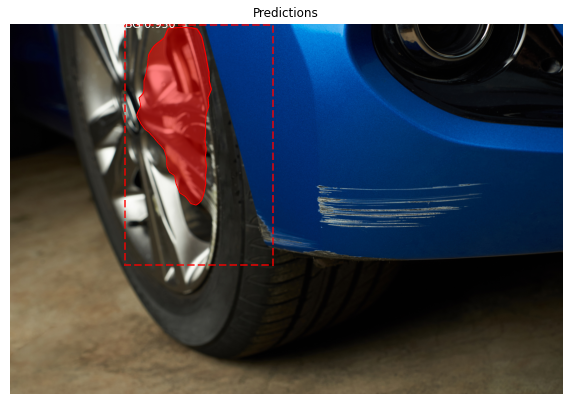

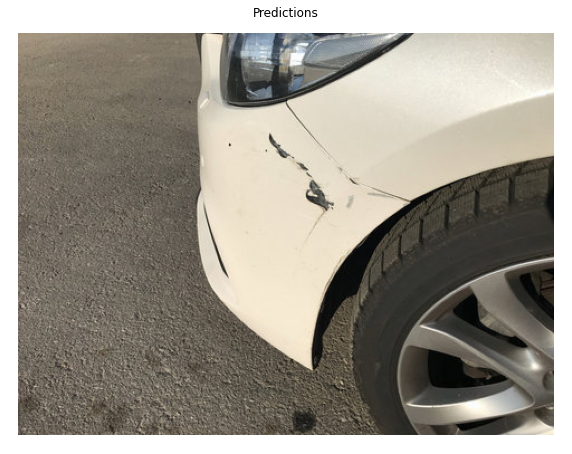

In [57]:
# Inference configuration   
infConfig = InferenceConfig()

# Consider the last training "folder" and the weights of the last epoch
logs_dir = sorted(os.listdir("logs"))
last_logs_dir = os.path.join("logs", logs_dir[-1])
weights_dir = sorted(os.listdir(last_logs_dir))
trained_weights_path = os.path.join(last_logs_dir, weights_dir[-1])

# Create model in inference mode
model = modellib.MaskRCNN(mode="inference", config=infConfig, model_dir=logs)

# Loading pre-trained weights excluding the last layers because they require a matching number of classes
print("Loading weights from", trained_weights_path)
model.load_weights(trained_weights_path, by_name=True)


for filename in os.listdir(test_images):
    
    image_path = os.path.join(test_images, filename)
    image = skimage.io.imread(image_path)

    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    ax = get_ax(1, size=10)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                ["damage", "BG"], r['scores'], ax=ax,
                                title="Predictions")
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

## **5) Analyze weights**

In [58]:
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1_14/kernel:0,"(7, 7, 3, 64)",-0.8546,+0.8473,+0.1305
conv1_14/bias:0,"(64,)",-0.0001,+0.0001,+0.0000
bn_conv1_14/gamma:0,"(64,)",+0.0835,+2.6244,+0.5057
bn_conv1_14/beta:0,"(64,)",-2.3942,+5.3658,+1.9789
bn_conv1_14/moving_mean:0,"(64,)",-172.9685,+94.5717,+42.0063
bn_conv1_14/moving_variance:0*** Overflow?,"(64,)",+0.0000,+110557.9688,+16228.7607
res2a_branch2a_14/kernel:0,"(1, 1, 64, 64)",-0.6536,+0.3163,+0.0762
res2a_branch2a_14/bias:0,"(64,)",-0.0008,+0.0029,+0.0007
bn2a_branch2a_14/gamma:0,"(64,)",+0.2169,+1.8489,+0.4113
bn2a_branch2a_14/beta:0,"(64,)",-2.1180,+3.7337,+1.1790


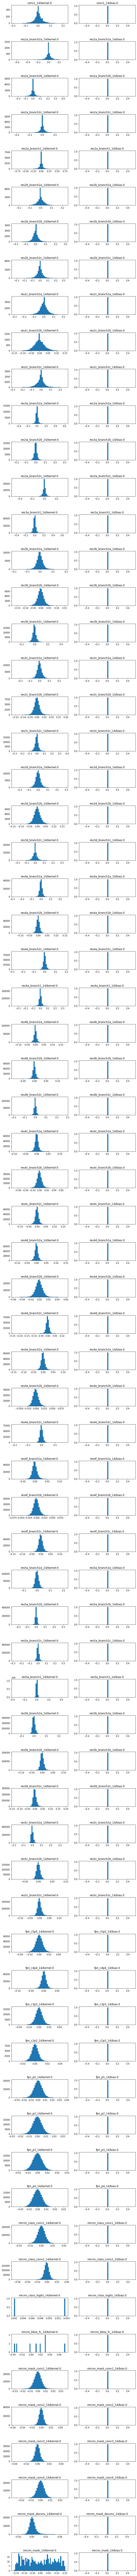

In [59]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)